In [ ]:
#Colab Path:
from google.colab import drive
drive.mount("/content/drive",force_remount = False)
my_path = "/CSE_Projekt_Meniskus/Neural_Network/MRI_raw_data"
gdrive_path = "/content/drive/My Drive" + my_path

Mounted at /content/drive


In [1]:
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
import nibabel
from matplotlib import colors
import tensorflow as tf
from keras.models import Model
#from keras.layers import Input, merge, Convolution3D, MaxPooling3D, UpSampling3D
from keras.layers import Dropout, GaussianNoise
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
#from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.layers import Dropout
from keras.losses import mean_absolute_error
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.losses import categorical_crossentropy
#from keras.layers.merge import concatenate
from sklearn.model_selection import train_test_split
from keras import callbacks
import h5py
from keras.callbacks import CSVLogger
import keras
import pandas as pd
from skimage import exposure

In [6]:
# Dateipfad für Training-, Valdidierung- und Test-Dateien
#TRAIN_DATASET_PATH = "/content/drive/My Drive"+"/Colab_Notebooks/data/training_data/singles/"
TRAIN_DATASET_PATH = "../../data/training_data/OAI_single/"

In [7]:
# Namen für Training-, Valdidierungs- und Test-Files
N_PATIENTS=25
STRUCT = "Femur"


TRAIN_FILE="MenisKI21_Training_"+str(N_PATIENTS)+"_"+STRUCT+".h5"
TEST_FILE="MenisKI21_Test_"+str(N_PATIENTS)+"_"+STRUCT+".h5"
PREDICTION_FILE="MenisKI21_Prediction_"+str(N_PATIENTS)+"_"+STRUCT+".h5"

In [8]:
# Parameter
VOLUME_SLICES_PER_BATCH = 16
IMG_SIZE_2=384
IMG_SIZE = 384

In [5]:
smoothDSC = np.finfo(float).eps

# DICE Coeffizient für 3 Klassen Segmentierung
def dice_coef(y_true, y_pred, smooth=smoothDSC):
    class_num = 2
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss
 
# Inspiriert durch https://github.com/keras-team/keras/issues/9395

# DICE Coefficient für Mensiskus medialis
def dice_coef_medial(y_true, y_pred,epsilon=np.finfo(float).eps):
    y_true_f = K.flatten(y_true[:,:,:,5])
    y_pred_f = K.flatten(y_pred[:,:,:,5])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon) / (K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)

def dice_coef_lateral(y_true, y_pred,epsilon=np.finfo(float).eps):
    y_true_f = K.flatten(y_true[:,:,:,6])
    y_pred_f = K.flatten(y_pred[:,:,:,6])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon) / (K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)

def dice_coef_tibia(y_true, y_pred,epsilon=np.finfo(float).eps):
    y_true_f = K.flatten(y_true[:,:,:,3])
    y_pred_f = K.flatten(y_pred[:,:,:,3])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon) / (K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)

def dice_coef_femur(y_true, y_pred,epsilon=np.finfo(float).eps):
    y_true_f = K.flatten(y_true[:,:,:,1])
    y_pred_f = K.flatten(y_pred[:,:,:,1])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon) / (K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)

def dice_coef_C_tibia(y_true, y_pred,epsilon=np.finfo(float).eps):
    y_true_f = K.flatten(y_true[:,:,:,4])
    y_pred_f = K.flatten(y_pred[:,:,:,4])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon) / (K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)

def dice_coef_C_femur(y_true, y_pred,epsilon=np.finfo(float).eps):
    y_true_f = K.flatten(y_true[:,:,:,2])
    y_pred_f = K.flatten(y_pred[:,:,:,2])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon) / (K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)

# Präzsion
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Sensitivität   
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Spezifität
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
# Erstelle UNet Segmentierungsmodell (nicht kompiliert)
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, (5, 5), padding="same", activation="relu", kernel_initializer = ker_init)(inputs)
    D1=Dropout(dropout)(conv1)
    conv1 = Conv2D(32, (5, 5), padding="same", activation="relu", kernel_initializer = ker_init)(D1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (5, 5), padding="same", activation="relu", kernel_initializer = ker_init)(pool1)
    D2=Dropout(dropout)(conv2)
    conv2 = Conv2D(64, (5, 5), padding="same", activation="relu", kernel_initializer = ker_init)(D2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (5, 5), padding="same", activation="relu", kernel_initializer = ker_init)(pool2)
    D3=Dropout(dropout)(conv3)
    conv3 = Conv2D(128, (5, 5), padding="same", activation="relu", kernel_initializer = ker_init)(D3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv5 = Conv2D(256, (5, 5), padding="same", activation="relu", kernel_initializer = ker_init)(pool3)
    D5=Dropout(dropout)(conv5)
    conv5 = Conv2D(256, (5, 5), padding="same", activation="relu", kernel_initializer = ker_init)(D5)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv3], axis=-1)
    conv7 = Conv2D(128, (5, 5), padding="same", activation="relu", kernel_initializer = ker_init)(up7)
    D7=Dropout(dropout)(conv7)
    conv7 = Conv2D(128, (5, 5), padding="same", activation="relu", kernel_initializer = ker_init)(D7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, (5, 5), padding="same", activation="relu", kernel_initializer = ker_init)(up8)
    D8=Dropout(dropout)(conv8)
    conv8 = Conv2D(64, (5, 5), padding="same", activation="relu", kernel_initializer = ker_init)(D8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, (5, 5), padding="same", activation="relu", kernel_initializer = ker_init)(up9)
    D9=Dropout(dropout)(conv9)
    conv9 = Conv2D(32, (5, 5), padding="same", activation="relu", kernel_initializer = ker_init)(D9)

    conv10 = Conv2D(2, (1, 1), activation="softmax")(conv9)

    return Model(inputs = inputs, outputs = conv10)

# Füge Eingabeschicht hinzu
input_layer = Input((IMG_SIZE, IMG_SIZE_2,1))

# Erstelle UNet Modell
model = build_unet(input_layer, 'he_normal', 0.15)

# Kompiliere UNet Modell mit categorical_crossentropy als Kostenfunktion, Adam als Optimierer und verschiedene Metriken
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0005), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef, precision, sensitivity, specificity] )

In [ ]:
# Erstelle Listen mit Keys für Training, Validierung und Test. Nur String pro Datensatz -> Endung "_dcm" bzw. "_seg" wird entfernt
with h5py.File(TRAIN_DATASET_PATH+TRAIN_FILE, 'r') as hf:
  train_ids= [s[:-4] for s in list(hf.keys()) if "Training" in s.split("_") and "dcm" in s.split("_")]
  validation_ids= [s[:-4] for s in list(hf.keys()) if "Validation" in s.split("_") and "dcm" in s.split("_")]
#with h5py.File(TRAIN_DATASET_PATH+TEST_FILE, 'r') as hf:
 # test_ids= [s[:-4] for s in list(hf.keys()) if "Test" in s.split("_") and "dcm" in s.split("_")]

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Erzeugt Daten für Keras'
    def __init__(self, list_IDs, filepath, slices=VOLUME_SLICES_PER_BATCH, dim=(IMG_SIZE,IMG_SIZE_2), batch_size = 1, n_channels = 1, shuffle=True):
        'Initialisierung'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.filepath=filepath
        self.slices=slices

    def __len__(self):
        'Bezeichnet die Anzahl der Batches pro Epoche'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Erzeuge eine Batch von Daten'
        # Erzeugen von Indizes für Batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Liste der IDs finden
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Daten generieren
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Aktualisiert Indizes nach jeder Epoche'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Erzeugt Daten, die Stichproben von batch_size enthalten' # X : (n_samples, *dim, n_channels); Y : (n_samples, *dim, n_classes=3)
        # Initialisierung
        X = np.zeros((self.batch_size*self.slices, *self.dim, self.n_channels))
        Y = np.zeros((self.batch_size*self.slices, *self.dim, 2))

        with h5py.File(self.filepath, 'r') as hf:
        # Daten generieren
          for c, i in enumerate(Batch_ids):        
          
            X[self.slices*c:self.slices*(c+1),:,:,:] = np.reshape(hf[i+'_dcm'][:],(self.slices,IMG_SIZE, IMG_SIZE_2,1))
            Y[self.slices*c:self.slices*(c+1),:,:,:] = to_categorical(hf[i+'_seg'][:], num_classes=2)

        return X, Y

In [ ]:
# Erstelle DataGenerator für Training, Validierung und Test
training_generator = DataGenerator(train_ids,TRAIN_DATASET_PATH+TRAIN_FILE)
valid_generator = DataGenerator(validation_ids,TRAIN_DATASET_PATH+TRAIN_FILE)
#test_generator = DataGenerator(test_ids,TRAIN_DATASET_PATH+TEST_FILE)
shape = model.get_weights()

In [ ]:
# Setze Keras-Session zurück
K.clear_session()

# Data Logger für Training
csv_logger = CSVLogger(TRAIN_DATASET_PATH+'training_singles_'+STRUCT+'.log', separator=',', append=False)

# Rückgaben für Training -> EarlyStopping um Training abzubrechen, falls keine Verbesserung mehr stattfindet und ReduceLROnPlateau, um Lernrate zu reduzieren
callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=4, verbose=1, mode='auto'),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=2, min_lr=0.000001, verbose=1),
             csv_logger]

# Trainiere UNet
history =  model.fit(training_generator,
                    epochs=50,
                    steps_per_epoch=len(train_ids),
                    validation_data = valid_generator,
                    callbacks= callbacks)

Epoch 1/30
300/300 [==============================] - 367s 1s/step - loss: 0.1854 - accuracy: 0.9573 - mean_io_u: 0.4748 - dice_coef: 0.6034 - precision: 0.9573 - sensitivity: 0.9573 - specificity: 0.9573 - val_loss: 0.1321 - val_accuracy: 0.9563 - val_mean_io_u: 0.3282 - val_dice_coef: 0.6556 - val_precision: 0.9563 - val_sensitivity: 0.9563 - val_specificity: 0.9563 - lr: 5.0000e-04
Epoch 2/30
300/300 [==============================] - 336s 1s/step - loss: 0.0865 - accuracy: 0.9715 - mean_io_u: 0.4102 - dice_coef: 0.7541 - precision: 0.9715 - sensitivity: 0.9715 - specificity: 0.9715 - val_loss: 0.0694 - val_accuracy: 0.9756 - val_mean_io_u: 0.4210 - val_dice_coef: 0.8099 - val_precision: 0.9756 - val_sensitivity: 0.9756 - val_specificity: 0.9756 - lr: 5.0000e-04
Epoch 3/30
300/300 [==============================] - 337s 1s/step - loss: 0.0524 - accuracy: 0.9804 - mean_io_u: 0.4532 - dice_coef: 0.8407 - precision: 0.9804 - sensitivity: 0.9804 - specificity: 0.9804 - val_loss: 0.0469 

In [ ]:
import datetime
now = datetime.datetime.now()
print(now)

In [ ]:
# Speichere Modell
model.save(TRAIN_DATASET_PATH+"model_singles_"+STRUCT+".h5")

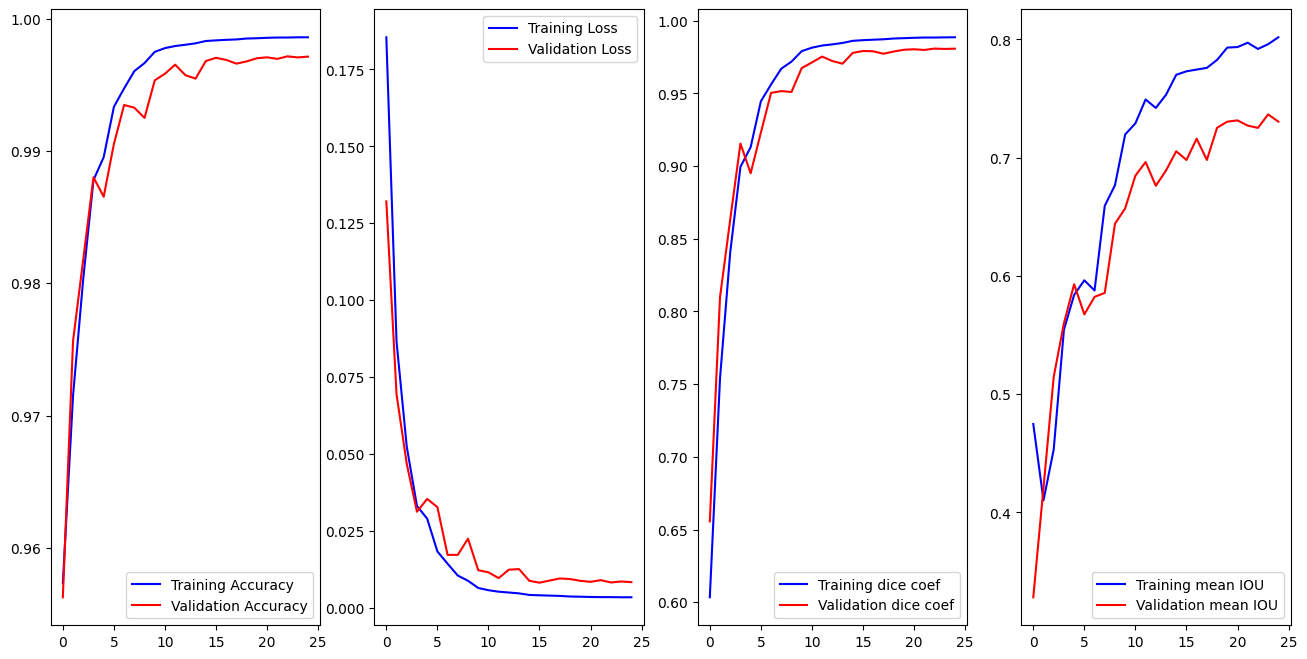

In [11]:
# Plotte Trainingsparameter
hist = pd.read_csv(TRAIN_DATASET_PATH+'logs/training_singles_Tibia_.log', sep=',', engine='python')

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [ ]:
# Test (Evaluation) des UNets
results = model.evaluate(test_generator, batch_size=1)